# Final Project - Piano Roll Extraction -SRC
- Course: AAI-511-Neural Networks
- Institution: University of San Diego
- Professor: Kahila Mokhtari Jadid
- Group 4 Members: 
    * Lucas Young
    * Titouan Margret
    * Juan Pablo Triana Martinez

This notebook has the intention to follow `data_piano_roll_extraction.ipynb`, but using `src` folder with all functions and classes, with the purpose to:

### CNN-LSTM Model

The following document contains the following:
1. Obtain all piano rolls with certain threshold, as well as appropiate labels.
2. Split the data into `train_set` and `test_set` using an 80:20 ratio.
3. We would set up a `train_dataset` and `test_dataset` using `torch.utils.data.Dataset`.
4. We would set up a `train_dataloader` and `test_dataloader` using `torch.utils.data.Dataloader` with Batch size = 32.
5. Setup a `torch.nn` CNN model with the following characteristics:
    - Optimizer: Adam with lr = 0.001
    - Loss function: Cross Entrpy Loss with weights.
    - Same number of layers, we would change the 
6. Plot the `train_loss` and `test_loss`, combined with proper metrics: (Accuracy, Precision, Recall, F1-score)
7. Using that trained model, visualize the learned features across different 

In [69]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import os

path = Path().resolve().parent
notebook_path = str(path)
print(path)
print(path.exists())
sys.path.insert(1, notebook_path) 

C:\Users\ajedr\OneDrive\Documentos\Masters_Post_Cert_AI_Stanford_USD_2023_2026\Masters_AI_Workspace\src\MSAAI-511-group-4
True


In [70]:
#Import necessary modules
import os
import numpy as np
import kagglehub
from src import MidiPreprocesser, obtain_piano_rolls, PianoRollsDiscreteEqualizer

In [71]:
# Obtain current path and data folder path
curr_path = Path.cwd()
download_path = curr_path.parent / "data"
data_path = download_path / "final_proj_data"

#Setup download path to specific data fold (GENUIENLY, Why Kaggelhub :) )
os.environ["KAGGLEHUB_CACHE"] = download_path.__str__()

if download_path.exists():
    print(f"{download_path}: Already exists, no need to create a new one")
else:
    download_path.mkdir(parents=True, exist_ok=True)

if data_path.exists():
    print(f"{data_path}: Already exists, no need to create a new one")
else:
    data_path.mkdir(parents=True, exist_ok=True)

# Download latest version
# path = kagglehub.dataset_download("blanderbuss/midi-classic-music")
# print("Path to dataset files:", path)

c:\Users\ajedr\OneDrive\Documentos\Masters_Post_Cert_AI_Stanford_USD_2023_2026\Masters_AI_Workspace\src\MSAAI-511-group-4\data: Already exists, no need to create a new one
c:\Users\ajedr\OneDrive\Documentos\Masters_Post_Cert_AI_Stanford_USD_2023_2026\Masters_AI_Workspace\src\MSAAI-511-group-4\data\final_proj_data: Already exists, no need to create a new one


In [72]:
midipreprocesser = MidiPreprocesser(data_path = data_path)
midiobj, labels_composer = midipreprocesser.get_midi_info()

Reading_final_proj_data files...: 0it [00:00, ?it/s]
Reading_Bach files...: 100%|██████████| 122/122 [00:03<00:00, 35.34it/s]
Reading composers..: 2it [00:03,  1.73s/it]

Anhang 14-3.mid cannot be read, is skipped


Reading_Mozart files...: 100%|██████████| 90/90 [00:03<00:00, 27.14it/s]
Reading composers..: 5it [00:18,  3.79s/it]


In [ ]:
list_np_arrays, list_composer_names, list_song_names = obtain_piano_rolls(midiobject = midiobj)

In [74]:
equalizer = PianoRollsDiscreteEqualizer(piano_rolls = list_np_arrays, threshold = 2515)
eq_piano_rolls = equalizer.get_equalized()

Equalizing piano rolls...: 100%|██████████| 480/480 [00:00<00:00, 4363.80it/s]


In [75]:
print(eq_piano_rolls.shape)
print(len(labels_composer))

(480, 128, 2515)
480


### Let's see the labels distribution.
What we want to do is to create a function that does the following:
1. Receive the `labels_composer` and determine the unique labels.
2. Count the number of times per label
3. Use these counts to create the classes

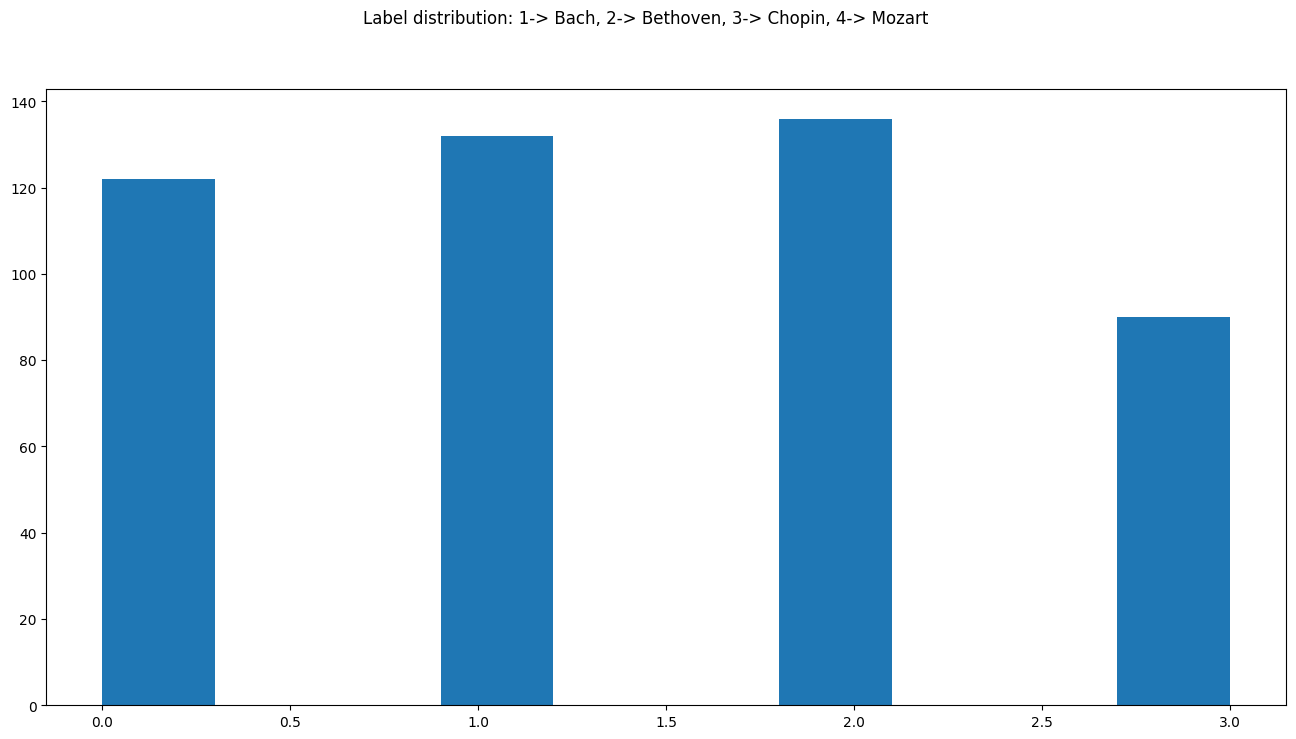

In [76]:
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Label distribution: 1-> Bach, 2-> Bethoven, 3-> Chopin, 4-> Mozart")
ax1 = fig.add_subplot(1, 1, 1)
ax1.hist(labels_composer)
plt.show()

In [77]:
# Let's import the necessary modules
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
from typing import Union, Tuple
import torch
import matplotlib.pyplot as plt

### Perfect, now let's do:

1. We would set up a `train_dataset` and `test_dataset` using `torch.utils.data.Dataset` 
2. We would set up a `train_dataloader` and `test_dataloader` using `torch.utils.data.Dataloader` with Batch size = 32.

In [78]:
class CNNLSTMPianoDataset(Dataset):
    '''
    Flavia Dataset class that would contain all of
    the passed data and labels.

    Args: 
        data: np.ndarray containing all of the data (N, 128, T)
        label: np.ndarray containing all of the data of size (N, )
        seq_length: integer defining sequence length size.

    Returns
        flaviadataset = a torch.utils.Dataset that would
        access the corresponding data folder to retrieve
        all required images and labels.

    Example
        cnn_piano_dataset = CNNLSTMPianoDataset(data = np_data, label = np_label)
        (img , label) = Preflaviadataset[0]
    '''
    def __init__(self,
                data:np.ndarray,
                label:np.ndarray,
                seq_Length:int = 4) -> None:
        super().__init__()

        # Let's obtain the torch.tensor
        self.data = torch.from_numpy(data).to(torch.float32).unsqueeze(dim=1) # Data shape: (N, 1, 128, 2515)
        self.label = torch.from_numpy(label).type(torch.LongTensor) # Data Label: (N, 1)
        self.seq_length = seq_Length
    
    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        data = self.data[idx:idx + self.seq_length] # shape (seq_length, 1, 128, 2515)
        label = self.label[idx + self.seq_length - 1] # shape (seq_length, )
        return data, label

In [79]:
# Let's setup a sequence length of 4
SEQ_LENGTH = 4

cnn_piano_dataset = CNNLSTMPianoDataset(
    data = eq_piano_rolls,
    label = np.array(labels_composer),
    seq_Length=SEQ_LENGTH)

# Let's see the shape
index = 200
(img , label) = cnn_piano_dataset[index]
print(f"Sample image for: label -> {label}, {label.shape}; img -> {img.shape}; Song: -> {list_song_names[index]}")

Sample image for: label -> 1, torch.Size([]); img -> torch.Size([4, 1, 128, 2515]); Song: -> Sieben Bagatellen, C Major, Opus.33, No.2


### Now let's do the following!
1. We are gonna split into train, val, and test data using `train_test_split` from `sklean.model_selection`.



In [80]:
# Import necessary modules
from sklearn.model_selection import train_test_split

# Obtain the data into train_val and test
X_train, X_remaining, y_train, y_remaining = train_test_split(eq_piano_rolls,
    np.array(labels_composer), test_size=0.2, shuffle=True, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, 
    test_size=0.5, shuffle=True, random_state=42)

print("==================================")
print(f"X_train piano roll data shape: {X_train.shape}")
print(f"y_train piano roll data shape: {y_train.shape}")
print(f"X_val piano roll data shape: {X_val.shape}")
print(f"y_val piano roll data shape : {y_val.shape}")
print(f"X_test piano roll data shape : {X_test.shape}")
print(f"y_test piano roll data shape : {y_test.shape}")
print("==================================")

X_train piano roll data shape: (384, 128, 2515)
y_train piano roll data shape: (384,)
X_val piano roll data shape: (48, 128, 2515)
y_val piano roll data shape : (48,)
X_test piano roll data shape : (48, 128, 2515)
y_test piano roll data shape : (48,)


In [81]:
from typing import List
def counts_labels(labels: List[int]) -> dict:
    # Count each label
    counts = {}
    for i in labels:
        if i in counts:
            counts[i] += 1
        else:
            counts[i] = 1
    
    # Compute class percentages
    class_percs = []
    for i in range(len(counts)):
        value = counts[i]
        class_percs.append(value/len(labels))

    # Reverse rank the percentages
    sorted_percs = sorted(class_percs, reverse=True)
    reversed_percs = sorted(sorted_percs)  # the smallest to largest

    # Map each original percentage to its reversed rank
    mapping = {}
    for orig, rev in zip(sorted_percs, reversed_percs):
        mapping[orig] = rev

    # Apply the reversed mapping preserving the original order
    adjusted_percentages = [mapping[p] for p in class_percs]

    return counts, class_percs, adjusted_percentages


In [82]:
### Return the counts
y_train_counts, y_train_percs, y_train_rev_percs = counts_labels(y_train)
print(y_train_percs)
print(y_train_percs)
print(y_train_rev_percs)

[0.2421875, 0.2916666666666667, 0.2916666666666667, 0.17447916666666666]
[0.2421875, 0.2916666666666667, 0.2916666666666667, 0.17447916666666666]
[0.2916666666666667, 0.2421875, 0.2421875, 0.2916666666666667]


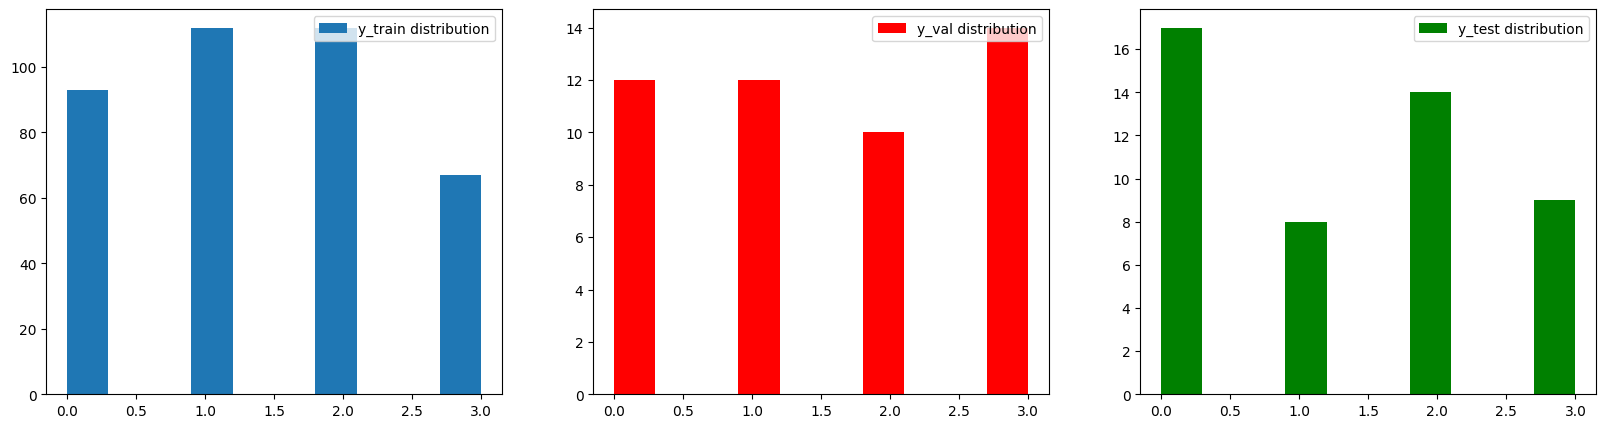

In [83]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.hist(y_train, label = "y_train distribution")
ax1.legend(loc = "upper right")
ax2 = fig.add_subplot(1, 3, 2)
ax2.hist(y_val, label = "y_val distribution", color="red")
ax2.legend(loc = "upper right")
ax3 = fig.add_subplot(1, 3, 3)
ax3.hist(y_test, label = "y_test distribution", color = "green")
ax3.legend(loc = "upper right")
plt.show()

### Its key to see these distributions
1. Our baseline model is dependent on directly the data with the range of the `velocity` from MIDI files, which is between 0 to 128.
2. We haven't done any standardization or normalization, we want to see the model performance with data that is not tempered.
3. We are not adata augmenting or undersampling, the reason is simple; due to constraints of time, a proper data balancing is a bit too much for a baseline model. We would however do the balancing for the **CNN-LSTM approach**.

In [84]:
# Lets obtain the housing datasets for all
SEQ_LENGTH = 2

X_train_dataset = CNNLSTMPianoDataset(X_train, y_train, SEQ_LENGTH)
X_val_dataset = CNNLSTMPianoDataset(X_val, y_val, SEQ_LENGTH)
X_test_dataset = CNNLSTMPianoDataset(X_test, y_test, SEQ_LENGTH)

index = 5
data, label = X_train_dataset[index]
print(f"For index {index}, data shape: {data.shape}, label shape {label}")
data, label = X_val_dataset[index]
print(f"For index {index}, data shape: {data.shape}, label shape {label}")
data, label = X_test_dataset[index]
print(f"For index {index}, data shape: {data.shape}, label shape {label}")

For index 5, data shape: torch.Size([2, 1, 128, 2515]), label shape 1
For index 5, data shape: torch.Size([2, 1, 128, 2515]), label shape 2
For index 5, data shape: torch.Size([2, 1, 128, 2515]), label shape 1


In [85]:
BATCH_SIZE = 10
#NUM_WORKERS = os.cpu_count()
NUM_WORKERS = 0

train_dataloader = DataLoader(
    dataset=X_train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS,
    pin_memory = True
)

val_dataloader = DataLoader(
    dataset=X_val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    pin_memory=True)

test_dataloader = DataLoader(
    dataset=X_test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    pin_memory=True)

a, b = next(iter(train_dataloader))
print(a.shape)
print(b.shape)
print(len(train_dataloader))

torch.Size([10, 2, 1, 128, 2515])
torch.Size([10])
39


c:\Users\ajedr\OneDrive\Documentos\Masters_Post_Cert_AI_Stanford_USD_2023_2026\Masters_AI_Workspace\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


### Stepping through a sample
1. To check weather the model would behave properly,
2. Our input is the format of: `(Batch_size, Seq_length, Height, Width)`
2. For the CNN-LSTM Mode, we would use the convolution layers as extractors `(Batch_size * Seq_Length, Channels, Height, Width)`
3. We would use the LSTM model to take an input of size `(Batch_size, )`

In [86]:
import torch.nn as nn

# Let's get a sample from train dataloader
X_sample, y_sample = next(iter(train_dataloader))

# Pass the data through the convolutional layer
Batch_size, Seq_length, Channel_in, Height, Width = X_sample.shape

print(f"Batch_size: {Batch_size}")
print(f"Seq_Length: {Seq_length}")
print(f"Channel_in: {Channel_in}")
print(f"Height: {Height}")
print(f"Width: {Width}")

conv_layer_1 = nn.Conv2d(in_channels = Channel_in,
                       out_channels = 10,
                       kernel_size= 3,
                       stride = 1,
                       padding = 0)


conv_layer_2 = nn.Conv2d(in_channels = 10,
                       out_channels = 10,
                       kernel_size= 3,
                       stride = 1,
                       padding = 0)

max_pool_layer = nn.MaxPool2d(kernel_size=2)

print(X_sample.shape)
conv_output_1 = conv_layer_1(X_sample.view(Batch_size * Seq_length, Channel_in, Height, Width))
print(conv_output_1.shape)
conv_output_2 = conv_layer_2(conv_output_1)
print(conv_output_2.shape)
output = max_pool_layer(conv_output_2)
print(output.shape)

Batch_size: 10
Seq_Length: 2
Channel_in: 1
Height: 128
Width: 2515
torch.Size([10, 2, 1, 128, 2515])
torch.Size([20, 10, 126, 2513])
torch.Size([20, 10, 124, 2511])
torch.Size([20, 10, 62, 1255])


### 8. Create a CNN model using `torch.nn`

We are gonna also test that it receives the proper input

In [87]:
import torch
from torch import nn

class TinyVGGLSTM(nn.Module):
  '''
  Creates the TinyVGGLSTM Architecture.

  Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
  See the original architecture here: https://poloclub.github.io/cnn-explainer/

  Also, we added from assignment 5 the LSTM layer to actually add the sequence analysis
  using the following logic:
  - Use CNN layers to extract features using input as x.view(B * Seq, C_in, H_in, W_in)
  - After extracting all CNN features, flatten the array to size (B * Seq, -1)
  - Reformat this CNN output latent vector space to x.view(B, Seq, -1)
  - Use this as input to the LSTM layer

  Args:
    batch_size: An integer indicaring number of batch_size (classifier parameter).
    cnn_input_shape: An integer indicating number of input for CNN channels.
    lstm_input_shape: An integet indicating number of input units for LSTM
    cnn_hidden_units: An integer indicating number of hidden units between cnn layers.
    lstm_hidden_units: An integer indicating number of hidden units for LSTM layer.
    output_shape: An integer indicating number of output units.
  '''
  def __init__(self,
      cnn_input_shape:int,
      lstm_input_shape:int,
      cnn_hidden_units:int,
      lstm_hidden_units:int,
      output_shape:int) -> None:

    super().__init__()
    self.cnn_hidden_units = cnn_hidden_units
    self.lstm_hidden_units = lstm_hidden_units
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=cnn_input_shape,
                  out_channels=cnn_hidden_units,
                  kernel_size=3, 
                  stride=1, 
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=cnn_hidden_units,
                  out_channels=cnn_hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                      stride=2) 
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(cnn_hidden_units, cnn_hidden_units, kernel_size=3, padding=0),
        nn.ReLU(),
        nn.Conv2d(cnn_hidden_units, cnn_hidden_units, kernel_size=3, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(cnn_hidden_units, cnn_hidden_units, kernel_size=3, padding=0),
        nn.ReLU(),
        nn.Conv2d(cnn_hidden_units, cnn_hidden_units, kernel_size=3, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.conv_block_4 = nn.Sequential(
        nn.Conv2d(cnn_hidden_units, cnn_hidden_units, kernel_size=3, padding=0),
        nn.ReLU(),
        nn.Conv2d(cnn_hidden_units, cnn_hidden_units, kernel_size=3, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )


    # Let's create the layers -> Batch, Seq, Input
    self.lstm_layer = torch.nn.LSTM(lstm_input_shape,
                                    lstm_hidden_units,
                                    batch_first=True)

    self.classifier = nn.Sequential(
        nn.Linear(lstm_hidden_units, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, output_shape)
    )

  def forward(self, x: torch.Tensor):

    # Pass the data through the convolutional layer
    Batch_size, Seq_length, Channel_in, Height, Width = x.shape

    # Pass the data through multiple convolution blocks to obtain better temporal features
    x = self.conv_block_1(x.view(Batch_size * Seq_length, Channel_in, Height, Width))
    x = self.conv_block_2(x)
    x = self.conv_block_3(x)
    x = self.conv_block_4(x)

    # Now let's flatten the convolution output to (Batch_size * Seq_length, all dims)
    cnn_output_flat = x.view(Batch_size * Seq_length, -1)

    # And now let's get the LSTM input to (Batch_size, Seq_length, dims)
    lstm_input = cnn_output_flat.view(Batch_size, Seq_length, -1)

    # lstm input shape is (4, 4, 6120) -? Different shapes to cnn_input_shape requires some testing
    # to match lstm_input_shape

    # Let's initialize a random hidden state and cell state h0 and c0
    h0 = torch.zeros(1, lstm_input.size(dim = 0), self.lstm_hidden_units, device=x.device)
    c0 = torch.zeros(1, lstm_input.size(dim = 0), self.lstm_hidden_units, device=x.device)
    out, __ = self.lstm_layer(lstm_input, (h0, c0))
    out = self.classifier(out[:, -1, :])

    return out

In [88]:
from torchinfo import summary

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
X_train_sample, y_train_sample = next(iter(train_dataloader))

# Pass the data through the convolutional layer
Batch_size, Seq_length, Channel_in, Height, Width = X_sample.shape

print(f"Batch_size: {Batch_size}")
print(f"Seq_Length: {Seq_length}")
print(f"Channel_in: {Channel_in}")
print(f"Height: {Height}")
print(f"Width: {Width}")

# Let's intialize the model (Batch, Seq, 1, 128, 2515)
model = TinyVGGLSTM(cnn_input_shape = Channel_in,
                lstm_input_shape = 6120,
                cnn_hidden_units = 10,
                lstm_hidden_units = 30,
                output_shape=len(np.unique(labels_composer))).to(device)
summary(model, input_size=(Batch_size,  Seq_length,\
         Channel_in, Height, Width))

Batch_size: 10
Seq_Length: 2
Channel_in: 1
Height: 128
Width: 2515


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGGLSTM                              [10, 4]                   --
├─Sequential: 1-1                        [20, 10, 62, 1255]        --
│    └─Conv2d: 2-1                       [20, 10, 126, 2513]       100
│    └─ReLU: 2-2                         [20, 10, 126, 2513]       --
│    └─Conv2d: 2-3                       [20, 10, 124, 2511]       910
│    └─ReLU: 2-4                         [20, 10, 124, 2511]       --
│    └─MaxPool2d: 2-5                    [20, 10, 62, 1255]        --
├─Sequential: 1-2                        [20, 10, 29, 625]         --
│    └─Conv2d: 2-6                       [20, 10, 60, 1253]        910
│    └─ReLU: 2-7                         [20, 10, 60, 1253]        --
│    └─Conv2d: 2-8                       [20, 10, 58, 1251]        910
│    └─ReLU: 2-9                         [20, 10, 58, 1251]        --
│    └─MaxPool2d: 2-10                   [20, 10, 29, 625]         --
├─Sequentia

In [89]:
model.eval()
with torch.inference_mode():
    ylogits = model(X_train_sample)
print(torch.softmax(ylogits, dim = 1))
print(torch.argmax(torch.softmax(ylogits, dim = 1), dim = 1))

tensor([[0.2423, 0.2471, 0.2642, 0.2465],
        [0.2417, 0.2479, 0.2631, 0.2473],
        [0.2411, 0.2474, 0.2657, 0.2459],
        [0.2436, 0.2430, 0.2634, 0.2500],
        [0.2425, 0.2461, 0.2626, 0.2488],
        [0.2415, 0.2478, 0.2648, 0.2460],
        [0.2410, 0.2462, 0.2641, 0.2487],
        [0.2422, 0.2475, 0.2646, 0.2457],
        [0.2411, 0.2473, 0.2648, 0.2468],
        [0.2427, 0.2473, 0.2642, 0.2459]])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


In [90]:
import torch.nn as nn
import torch

# With weights
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(y_train_rev_percs))

# Without weights
#loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

### Well, now happens the next part. training!
We would subdivide this into three main functions
1. `train_step` function to perform a single train step for a specific `batch` of data.
2. `test_step` function to perform a single test step for a specific `batch` of data.
3. `train` function that combines `train_step` and `test_step` to train a model.    

In [91]:
from typing import Tuple, Dict, List
from tqdm import tqdm

def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device:torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy mse metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)

  """
  # Put model in train mode
  model.train()

  # Setup train loss and train mse values
  train_loss, train_acc = 0, 0
  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_logits = model(X)

    # 2. Calculate the accumulate loss
    loss = loss_fn(y_logits, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()
    
    # 5. Optimizer step, step, step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_logits, dim = 1), dim = 1)
    train_acc += (y_pred_class == y).sum().item()/len(y_logits)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [92]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy mse metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put the model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on the inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send the data to target device
      X, y = X.to(device), y.to(device)

      #1. Forward pass
      y_logits = model(X)

      #2. Calculate and accumulate the loss
      loss = loss_fn(y_logits, y)
      test_loss += loss.item()

      # Calculate and accumualte accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_logits, dim = 1), dim = 1)
      test_acc += (y_pred_class == y).sum().item()/len(y_logits)

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [93]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
  # Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      if (epoch + 1) % 1 == 0: 
        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

### Let's train the model!

In [94]:
#Train the model
NUM_EPOCHS = 9
from timeit import default_timer as timer

# Start the timer
start_time = timer()

results = train(
  model=model,
  train_dataloader=train_dataloader,
  test_dataloader=val_dataloader,
  loss_fn=loss_fn,
  optimizer=optimizer,
  epochs=NUM_EPOCHS,
  device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 11%|█         | 1/9 [01:27<11:38, 87.29s/it]

Epoch: 1 | train_loss: 1.3843 | train_acc: 0.2308 | test_loss: 1.4116 | test_acc: 0.1800


 22%|██▏       | 2/9 [02:52<10:02, 86.00s/it]

Epoch: 2 | train_loss: 1.3702 | train_acc: 0.3179 | test_loss: 1.4030 | test_acc: 0.3733


 33%|███▎      | 3/9 [04:17<08:32, 85.48s/it]

Epoch: 3 | train_loss: 1.2849 | train_acc: 0.3872 | test_loss: 1.4081 | test_acc: 0.2800


 44%|████▍     | 4/9 [05:42<07:06, 85.33s/it]

Epoch: 4 | train_loss: 1.1439 | train_acc: 0.4769 | test_loss: 1.1619 | test_acc: 0.4467


 56%|█████▌    | 5/9 [07:06<05:39, 84.96s/it]

Epoch: 5 | train_loss: 0.9390 | train_acc: 0.6051 | test_loss: 0.9933 | test_acc: 0.6267


 67%|██████▋   | 6/9 [08:29<04:12, 84.28s/it]

Epoch: 6 | train_loss: 0.7178 | train_acc: 0.7308 | test_loss: 0.9050 | test_acc: 0.6333


 78%|███████▊  | 7/9 [09:53<02:48, 84.26s/it]

Epoch: 7 | train_loss: 0.6601 | train_acc: 0.7333 | test_loss: 0.8439 | test_acc: 0.7267


 89%|████████▉ | 8/9 [11:18<01:24, 84.27s/it]

Epoch: 8 | train_loss: 0.4251 | train_acc: 0.8590 | test_loss: 0.7971 | test_acc: 0.6800


100%|██████████| 9/9 [12:41<00:00, 84.63s/it]

Epoch: 9 | train_loss: 0.2203 | train_acc: 0.9333 | test_loss: 0.7215 | test_acc: 0.7400
[INFO] Total training time: 761.645 seconds


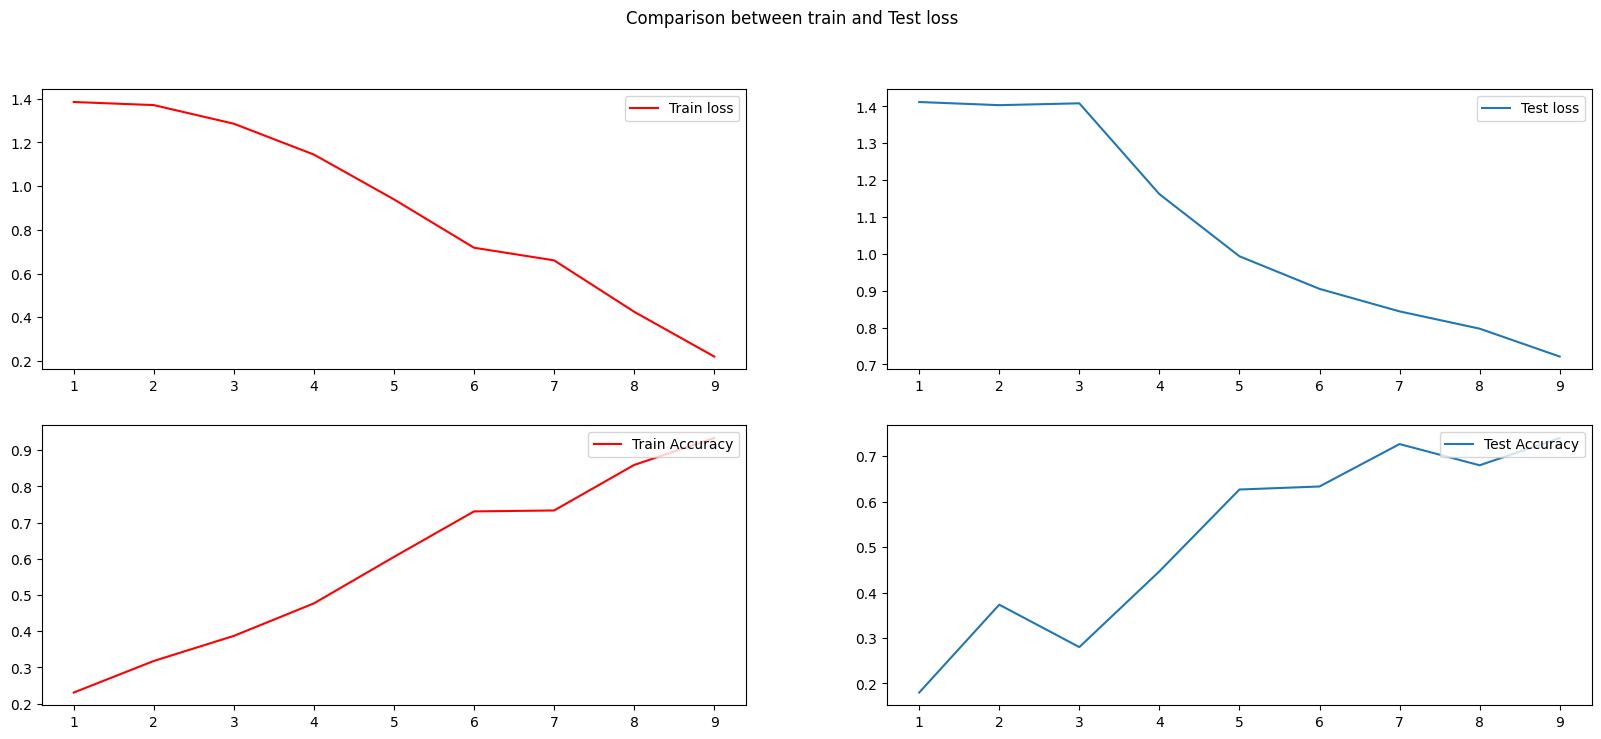

In [100]:
# Let's plot them
import matplotlib.pyplot as plt

# Obtain the train_loss and validation loss
train_loss = results["train_loss"]
test_loss = results["test_loss"]
train_accuracy = results["train_acc"]
test_accuracy = results["test_acc"]
epochs = range(1, len(train_loss) + 1)

# Let's plot it
fig = plt.figure(figsize=(20, 8))
fig.suptitle("Comparison between train and Test loss")
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(epochs, train_loss, label = "Train loss", color = "r")
ax1.legend(loc = "upper right")
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(epochs, test_loss, label = "Test loss")
ax2.legend(loc = "upper right")
ax1 = fig.add_subplot(2, 2, 3)
ax1.plot(epochs, train_accuracy, label = "Train Accuracy", color = "r")
ax1.legend(loc = "upper right")
ax2 = fig.add_subplot(2, 2, 4)
ax2.plot(epochs, test_accuracy, label = "Test Accuracy")
ax2.legend(loc = "upper right")
plt.show()

## Perfect!

The model has indeed trained and tested properly. Now we need to do the following:
- Evaluate the model: We would create an `model_eval()` function that would take the `test_dataloader` and retrieve the `y_predicted` and `y_test`.
- Using the`y_predicted` and `y_test`, calculate: Accuracy, Precision, Recall, F1-score.
- Analyze the results properly and see what might be necessary to increase the precision.
- Create a function called `visualize_conv_activation()` to see the outputs of each conv layers properly.

In [101]:
import numpy as np

def eval(model:torch.nn.Module,
         test_dataloader:DataLoader) -> None:
    '''
    Function that will evaluate the model.

    Args:
        model: nn.Module of model already trained
        test_dataloader: Dataloader containing all of the test data
    
    Returns:
        y_predictions, y_test = eval(model = trained_model,
                    test_dataloader = test_dataloader)
    '''
    y_predictions = []
    y_test = []

    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)
            y_logits = model(X)
            y_pred_class = torch.argmax(torch.softmax(y_logits, dim = 1), dim = 1)
            y_predictions.extend(y_pred_class.tolist())
            y_test.extend(y.tolist())
    return y_predictions, y_test

In [102]:
# Lte's obtain these
y_predictions, y_test = eval(model = model,
            test_dataloader = test_dataloader)

c:\Users\ajedr\OneDrive\Documentos\Masters_Post_Cert_AI_Stanford_USD_2023_2026\Masters_AI_Workspace\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [98]:
y_test[0], y_predictions[0]

(3, 3)

          accuracy    recall  precision  f1_score
CNN_LSTM  0.717391  0.708003   0.720899  0.706513


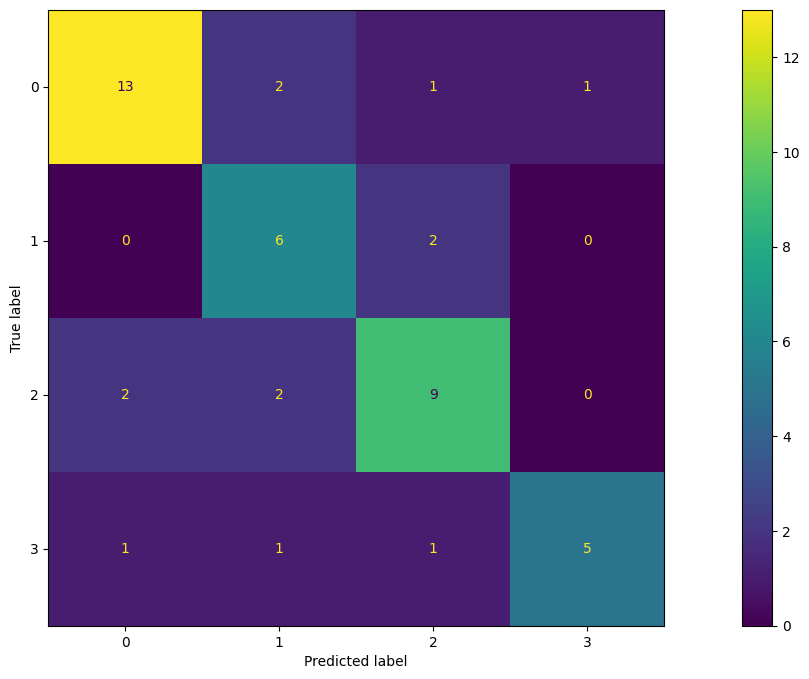

In [104]:
import pandas as pd

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay

data = {"accuracy": accuracy_score(y_test, y_predictions),
        "recall": recall_score(y_test, y_predictions, average="macro"),
        "precision": precision_score(y_test, y_predictions, average="macro"),
        "f1_score": f1_score(y_test, y_predictions, average="macro")}

df_results = pd.DataFrame([data], index=["CNN_LSTM"])
print(df_results)


fig, ax = plt.subplots(figsize=(20, 8))
cm = confusion_matrix(y_test, y_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()